In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("seaborn")

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetch the ethin dataset & Network

In [2]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset

dim = 38

S, P = np.load("../ethin/dataset_ethin_6-31g**.npy")
molecules = np.load("../ethin/molecules_ethin_6-31g**.npy")
dataset, molecules = make_butadien_dataset(molecules, S.reshape(-1, dim, dim), P.reshape(-1, dim, dim))

[-] 2018-09-10 10:59:53: Data set normalized. Mean value std: 0.02775708963766184


In [3]:
from SCFInitialGuess.nn.networks import EluFixedValue

graph = tf.Graph()

structure, weights, biases = np.load("../ethin/network_ethin.npy", encoding="latin1")

with graph.as_default():
    sess = tf.Session()
    network = EluFixedValue(structure, weights, biases)
    network.setup()
    sess.run(tf.global_variables_initializer())

In [4]:
from SCFInitialGuess.utilities.dataset import extract_triu
s_normed_triu = np.array(list(map(lambda x: extract_triu(x, dim), dataset.testing[0])))
s_triu = np.array(list(map(lambda x: extract_triu(x, dim), dataset.inverse_input_transform(dataset.testing[0]))))
s_test = dataset.inverse_input_transform(dataset.testing[0])

# calculate the guesses 

In [5]:
from pyscf.scf import hf
from SCFInitialGuess.utilities.dataset import make_matrix_batch
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny


# network requrires triu input, but dataset is not triu. Output is triu..
p_nn = network.run(sess, s_normed_triu)

p_batch = make_matrix_batch(p_nn, dim, True)
p_mcw1 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=1), zip(p_batch, s_test.reshape(-1, dim, dim)))))
p_mcw5 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=5), zip(p_batch, s_test.reshape(-1, dim, dim)))))

p_sad = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
])
p_1e = np.array([
    hf.init_guess_by_1e(mol.get_pyscf_molecule()) for mol in molecules[1]
])
p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
])

# differences 

In [6]:
expected = dataset.testing[1].flatten()
overlap = s_test.flatten()


In [7]:
def weighted_error(p):
    return np.abs(p.flatten() - expected) * overlap

e_batch = weighted_error(p_batch)
e_mcw1 = weighted_error(p_mcw1)
e_mcw5 = weighted_error(p_mcw5)
e_sad = weighted_error(p_sad)
e_1e = weighted_error(p_1e)
e_gwh = weighted_error(p_gwh)

# create the plot


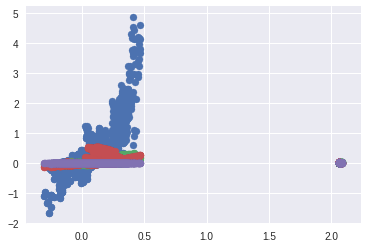

In [8]:
plt.scatter(expected, e_1e, label="H_Core")
plt.scatter(expected, e_gwh, label="GWH")
plt.scatter(expected, e_sad, label="SAD")
plt.scatter(expected, e_batch, label="NN")

plt.show()

In [9]:
ylim = [-0.5, 0.6]
xlim = [-0.35, 1]

label_fontsize = 20

/home/jcartus/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


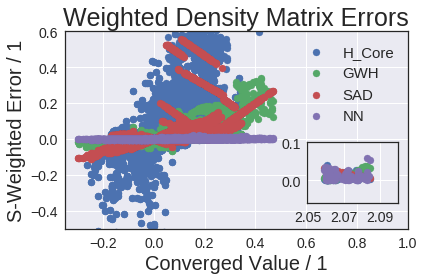

In [11]:
#--- outer ---
fig, ax = plt.subplots()

plt.scatter(expected, e_1e, label="H_Core")
plt.scatter(expected, e_gwh, label="GWH")
plt.scatter(expected, e_sad, label="SAD")
plt.scatter(expected, e_batch, label="NN")
#plt.scatter(expected, e_mcw1, label="McW-1")
#plt.scatter(expected, e_mcw5, label="McW-5")


plt.ylim(ylim)
plt.xlim(xlim)

plt.title("Weighted Density Matrix Errors", fontsize=25)
plt.ylabel("S-Weighted Error / 1", fontsize=label_fontsize)
plt.xlabel("Converged Value / 1", fontsize=label_fontsize)
plt.legend(fontsize=15)
plt.tick_params(labelsize=14)
#plt.tight_layout()

#--- insert ---
lower, upper = 2.0, 2.15
#ax_inner = inset_axes(ax, width="20%", height="25%", loc=7)
ax_inner = plt.axes([0.72, 0.28, 0.21, 0.21])
ax_inner.scatter(expected, e_1e, label="H_Core")
ax_inner.scatter(expected, e_gwh, label="GWH")
ax_inner.scatter(expected, e_sad, label="SAD")
ax_inner.scatter(expected, e_batch, label="NN")
#ax_inner.scatter(expected, e_mcw1, label="McW-1")
#ax_inner.scatter(expected, e_mcw5, label="McW-5")


plt.xlim(2.05, 2.1)
plt.ylim(-0.06, 0.1)
plt.xticks([2.05, 2.07, 2.09])
#plt.yticks([2.0,2.05, 2.1])
plt.tick_params(labelsize=14)

#plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.25
plt.tight_layout()
#---
plt.savefig("/home/jcartus/Repos/cc2aiPoster/figures/EthinOverlapWeightedError.pdf")
plt.show()